In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from mtcnn import MTCNN
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

import os
import re

from keras.layers import Embedding
from keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout
from tensorflow.keras.models import Model

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [3]:
df = pd.read_csv('MELD.Raw/dev_sent_emo.csv',encoding='utf-8')
df['Utterance'] = df.Utterance.str.replace('',"'")
# df['gender'] = df.Speaker.apply(lambda x: 'male' if x == 'Ross' or x == 'Joey' or x == 'Chandler' else 'female')
df = df.sample(n=3,ignore_index=True)


In [4]:
ohe = OneHotEncoder(categories=[df.Emotion.unique()])
labels = ohe.fit_transform(df.Emotion.to_numpy().reshape(-1,1)).toarray()

The function below has two parts: 1. a conv base that can return embeddings, 2. a trainable fully connected set of layers. The entire model will return a prediction, but it can be split into two so that it either returns embeddings OR a prediction. It can also be fine tuned using the relevant parameter. 

For early fusion, just use the embeddings, concat with bert embeddings and use the early fusion model.

For late fusion, use prediction and bert prediction and average.

In [95]:
# def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
#     """
#     Compiles a model integrated with VGG16 pretrained layers
    
#     input_shape: tuple - the shape of input images (width, height, channels)
#     n_classes: int - number of classes for the output layer
#     optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
#     fine_tune: int - The number of pre-trained layers to unfreeze.
#                 If set to 0, all pretrained layers will freeze during training
#     """
    
#     # Pretrained convolutional layers are loaded using the Imagenet weights.
#     # Include_top is set to False, in order to exclude the model's fully-connected layers.
#     conv_base = VGG16(include_top=False,
#                      weights='imagenet', 
#                      input_shape=input_shape)
    
#     # Defines how many layers to freeze during training.
#     # Layers in the convolutional base are switched from trainable to non-trainable
#     # depending on the size of the fine-tuning parameter.
#     if fine_tune > 0:
#         for layer in conv_base.layers[:-fine_tune]:
#             layer.trainable = False
#     else:
#         for layer in conv_base.layers:
#             layer.trainable = False

#     # Create a new 'top' of the model (i.e. fully-connected layers).
#     # This is 'bootstrapping' a new top_model onto the pretrained layers.
#     top_model = conv_base.output
#     top_model = Flatten(name="flatten")(top_model)
#     top_model = Dense(4096, activation='relu')(top_model)
#     top_model = Dense(1072, activation='relu')(top_model)
#     top_model = Dropout(0.2)(top_model)
#     output_layer = Dense(n_classes, activation='softmax')(top_model)
    
#     # Group the convolutional base and new fully-connected layers into a Model object.
#     model = Model(inputs=conv_base.input, outputs=output_layer)

#     # Compiles the model for training.
#     model.compile(optimizer=optimizer, 
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# input_shape = (224, 224, 3)
# n_classes=7
# optim_1 = Adam(learning_rate=0.001)


# # First we'll train the model without Fine-tuning
# face_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)


In [45]:
# face_model = tf.keras.models.Sequential()

# face_model.add(tf.keras.layers.Conv2D(50, (3, 3), strides=1, padding="same", activation="relu", 
#                 input_shape=(48, 48, 3)))


face_model = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet") #include_top=True for predictions, False for embeddings

#the (512,) array is result of maxpooling


In [6]:
detector = MTCNN()

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0 
    return img

def extract_face_embeddings(frame):
    global face_embedding
    faces = detector.detect_faces(frame)
    face_embeddings = []
    for face in faces:
        x, y, w, h = face['box']
        x1, y1 = max(x, 0), max(y, 0)
        x2, y2 = min(x + w, frame.shape[1]), min(y + h, frame.shape[0])
        cropped_face = frame[y1:y2, x1:x2]
        
        # Preprocess
        preprocessed_face = preprocess_image(cropped_face)
        preprocessed_face = np.expand_dims(preprocessed_face, axis=0)

        return preprocessed_face

        # face_embedding = face_model.predict(preprocessed_face)      # uncomment for predictions
        # face_embeddings.append(np.squeeze(face_embedding))
        
        # return face_embeddings

# Read video
folder_path = 'MELD.Raw/dev_splits_complete/'
one_face_videos = {}

for idx, row in df.iterrows():
    file_name = 'dia' + str(row['Dialogue_ID']) + '_utt' + str(row['Utterance_ID']) + '.mp4'
    video_path = folder_path + file_name
    if os.path.isfile(video_path):
        video_capture = cv2.VideoCapture(video_path)

        single_video_embeddings = []  # List to store embeddings for all frames

        frame_counter = 0

        while frame_counter < 2:
            ret, frame = video_capture.read()
            if not ret:
                break

            # check for more than 1 face
            if len(detector.detect_faces(frame)) == 1:

                # extract face embeddings from each frame
                extracted_embeddings = np.squeeze(extract_face_embeddings(frame))

                single_video_embeddings.append(extracted_embeddings)  # Append embeddings for this frame

                # bounding boxes
                for face in detector.detect_faces(frame):
                    x, y, w, h = face['box']
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

                cv2.imshow('Video', frame)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
                frame_counter += 1

            else:
                continue

        video_capture.release()
        cv2.destroyAllWindows()

        if single_video_embeddings != []:            
            one_face_videos[file_name] = np.squeeze(single_video_embeddings)
        else:
            one_face_videos[file_name] = 'too many faces'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━

In [55]:
#this includes xfer learning for vgg16. Switch the top layers to something appropriate. it works tho

for layer in face_model.layers:
    layer.trainable=True

base = face_model.output

flat = Flatten(name="flatten")(base)
output = (Dense(3, activation='softmax'))(flat)
model = Model(inputs=face_model.input,outputs=output)

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

x = []
for video in one_face_videos.values():
    video = tf.reduce_mean(video,axis=0)
    x.append(video)

x = np.array(x)

model.fit(x,labels)

In [88]:

#THIS SERVES NO PURPOSE ATM

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Assuming you have extracted embeddings and labels
# embeddings_data = extracted_embeddings_array
# labels = corresponding_labels_array

# Prepare your data (embeddings and labels)

# Define a new model
fine_tuned_model = Sequential()
fine_tuned_model.add(Flatten())  # Adjust input shape if necessary
fine_tuned_model.add(Dense(128, activation='relu'))  # Example additional dense layer
fine_tuned_model.add(Dense(len(df.Emotion.unique()), activation='softmax'))  # Output layer, adjust num_classes for your task

# Compile the model
fine_tuned_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
fine_tuned_model.fit(np.array([array for array in one_face_videos.values()]), labels, epochs=10, batch_size=32, validation_split=0.2)  # Adjust epochs, batch_size, and validation split as needed


Epoch 1/10
1/1 [==============================] - 1s 795ms/step - loss: 1.7473 - accuracy: 0.0000e+00 - val_loss: 16.8998 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 119ms/step - loss: 0.3429 - accuracy: 1.0000 - val_loss: 26.7468 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 119ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 35.5731 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 114ms/step - loss: 0.0264 - accuracy: 1.0000 - val_loss: 42.3718 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 112ms/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 47.9981 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 135ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 52.8797 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 123ms/step - loss: 1.8176e-04 - accuracy: 1.0000 - val_loss: 57.1738 - va

In [91]:
fine_tuned_model.predict(np.array([array for array in one_face_videos.values()]))

1/1 [==============================] - 0s 50ms/step


array([[1.0000000e+00, 1.9291693e-22, 1.5459363e-32],
       [3.6236133e-07, 9.9999964e-01, 0.0000000e+00],
       [1.0000000e+00, 2.6126169e-18, 5.1646539e-30]], dtype=float32)

In [15]:
df['many_faces'] = one_face_videos.values()

df = df[df.many_faces != 'too many faces']

print(len(df))

1


c:\Python311\Lib\site-packages\pandas\core\ops\array_ops.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [16]:
b = []

for value in one_face_videos.values():
    if value != 'too many faces':
        b.append(value)


visual = np.array(b)

C:\Users\gsevr\AppData\Local\Temp\ipykernel_2400\2504829242.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if value != 'too many faces':


In [17]:
padding_length = 30

from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def preprocess(text):
    t = text.lower()
    t = re.sub('\d+',r'',t)
    t = re.sub(r'\W+',r' ',t)
    return t

lemmatizer = WordNetLemmatizer()



df['prepro'] = [' '.join([lemmatizer.lemmatize(preprocess(txt))])
                 .strip() for txt in df['Utterance']]


texts = df.prepro.values
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(texts)


In [18]:
from gensim.models import KeyedVectors


glove_path = 'glove.6B.300d.txt'
word_vectors = KeyedVectors.load_word2vec_format(glove_path, binary=False, encoding='utf8',no_header=True)
glove_dims = 300



In [15]:


sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=padding_length, padding='post')

# X_train, X_test, y_train, y_test = train_test_split(texts, labels,test_size=0.25)

# sequences = tokenizer.texts_to_sequences(X_train)
# padded_sequences = pad_sequences(sequences, maxlen=padding_length, padding='post')

# test = tokenizer.texts_to_sequences(X_test)
# test_sequences = pad_sequences(test, maxlen=padding_length, padding='post')


AttributeError: 'BertTokenizer' object has no attribute 'texts_to_sequences'

In [20]:


embedding_dim = glove_dims  
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

embedding_layer = Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=padding_length,  #for matmul
    trainable=False
)

In [21]:
# text embeddings model

text_model = tf.keras.Sequential()

text_model.add(embedding_layer)

text_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics='accuracy')

text_embeddings = text_model.predict(padded_sequences)

1/1 [==============================] - 0s 35ms/step


In [22]:

agg_vis = []

for i in visual:
    agg_vis.append(tf.reduce_mean(i, axis=0))

agg_vis = np.array(agg_vis)

In [23]:
con_ten = []

for i in range(len(df)):
    con_ten.append(np.concatenate([text_embeddings.ravel(),agg_vis.ravel()]))

df['concat'] = con_ten

In [24]:
# To be used for early fusion

model = Sequential()


model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(len(df.Emotion.unique()), activation='relu'))


model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [25]:
history = model.fit(epochs=10,batch_size=32,x=np.stack(con_ten),y=labels)

Epoch 1/10


C:\Users\gsevr\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\util\dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 1s 779ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 8/10
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0000e+00
Epoch 10/10
1/1 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00


In [19]:
a = tokenizer(list(df.Utterance.values))
model.compile(optimizer='adam',loss='binary_crossentropy')

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(a),
    labels
)).shuffle(len(a)).batch(8)
model.fit(a,labels)

ValueError: Can't convert non-rectangular Python sequence to Tensor.

KeyError: 'val_loss'

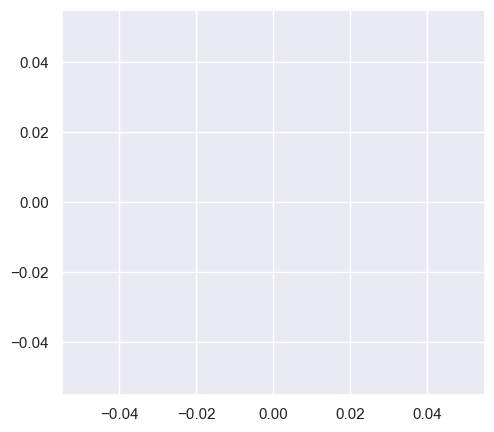

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks([i for i in range(0,20)])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','validation'],loc='upper right')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','validation'],loc='lower right')
plt.xticks([i for i in range(0,20)])

plt.show()